In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Define the Imputation Function (as provided/corrected earlier) ---

def impute_missing_with_prophet(dates, y):
    """
    Imputes missing values (NaN) in a time series using Prophet,
    ensuring that the imputed values are non-negative.
    """
    df = pd.DataFrame({'ds': dates, 'y': y})
    mask = ~np.isnan(y)
    df_train = df[mask].copy()

    if len(df_train) < 5:
        # Fallback to mean imputation
        mean_y = np.nanmean(y)
        mean_y = max(0, mean_y)
        y[np.isnan(y)] = mean_y
        return y

    m = Prophet(yearly_seasonality=True, daily_seasonality=False)
    m.fit(df_train)
    
    future = df[['ds']]
    forecast = m.predict(future)
    y_pred = forecast['yhat'].values
    
    # Non-negativity constraint applied to missing indices
    missing_indices = np.where(np.isnan(y))[0]
    predictions_for_missing = y_pred[missing_indices]
    constrained_predictions = np.maximum(0, predictions_for_missing)
    
    y[missing_indices] = constrained_predictions
    return y

# --- 2. Define the Testing Function ---

def test_imputation_accuracy(dates, values, gap_start_date, gap_end_date):
    """
    Tests the accuracy of the imputation model by creating a synthetic gap,
    imputing it, and calculating evaluation metrics.
    """
    
    # 1. Prepare Data and Identify Gap Indices
    df_test = pd.DataFrame({'ds': dates, 'y_true': values})
    
    start_dt = pd.to_datetime(gap_start_date)
    end_dt = pd.to_datetime(gap_end_date)
    
    # Identify the indices for the gap
    gap_mask = (df_test['ds'] >= start_dt) & (df_test['ds'] <= end_dt)
    gap_indices = df_test[gap_mask].index

    if len(gap_indices) == 0:
        print("Error: No data found within the specified gap dates.")
        return

    # 2. Create the Synthetic Missing Data (y_masked)
    # 💥 FIX APPLIED HERE: Convert the array to float before copying 💥
    y_masked = df_test['y_true'].values.astype(float).copy() 
    y_masked[gap_indices] = np.nan # Hide the true values
    
    # 3. Impute the Gap
    y_imputed = impute_missing_with_prophet(df_test['ds'].values, y_masked)

    # 4. Extract Results for Comparison
    y_true_gap = df_test.loc[gap_indices, 'y_true'].values
    y_imputed_gap = y_imputed[gap_indices]

    # 5. Calculate Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_true_gap, y_imputed_gap)
    rmse = np.sqrt(mean_squared_error(y_true_gap, y_imputed_gap))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    y_true_nonzero = np.where(y_true_gap == 0, 1e-6, y_true_gap)
    mape = np.mean(np.abs((y_true_gap - y_imputed_gap) / y_true_nonzero)) * 100

    # 6. Report Results
    print(f"\n--- Imputation Accuracy Test Results ({gap_start_date} to {gap_end_date}) ---")
    print(f"Total points in gap: {len(y_true_gap)}")
    print(f"Mean True Value in Gap: {np.mean(y_true_gap):.2f}")
    print(f"\nMetrics:")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print("-" * 60)
    
    return {
        'mae': mae, 
        'rmse': rmse, 
        'mape': mape,
        'true_values': y_true_gap,
        'imputed_values': y_imputed_gap
    }

# --- 3. Example Usage with Synthetic Data ---

# Create dummy data for testing (10 years of daily data)
N_DAYS = 10 * 365
dates_all = pd.date_range(start='2015-01-01', periods=N_DAYS, freq='D')

# Create a realistic time series (seasonal component + noise)
year_fraction = (dates_all.dayofyear - 1) / 365.0
seasonal_peak = np.maximum(0, 50 * np.sin(2 * np.pi * year_fraction - np.pi/4) + 50)
noise = np.random.normal(0, 5, N_DAYS)
values_complete = np.maximum(0, seasonal_peak + noise).astype(int)

# --- Define the Gap for Testing ---
# Choose a period that is typically non-missing (i.e., you have the ground truth)
TEST_GAP_START = '2023-04-01'
TEST_GAP_END = '2023-04-30'

print("Starting Imputation Accuracy Test...")
results = test_imputation_accuracy(
    dates=dates_all,
    values=values_complete,
    gap_start_date=TEST_GAP_START,
    gap_end_date=TEST_GAP_END
)

Starting Imputation Accuracy Test...


00:04:04 - cmdstanpy - INFO - Chain [1] start processing
00:04:04 - cmdstanpy - INFO - Chain [1] done processing



--- Imputation Accuracy Test Results (2023-04-01 to 2023-04-30) ---
Total points in gap: 30
Mean True Value in Gap: 90.47

Metrics:
  Root Mean Squared Error (RMSE): 4.99
  Mean Absolute Error (MAE): 4.23
  Mean Absolute Percentage Error (MAPE): 4.72%
------------------------------------------------------------


e:\GitHub\Cvetni_prah_v2\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Starting Prophet Imputation Accuracy Test for BUKEV in Ljubljana...


Cleaning values: 100%|██████████| 151218/151218 [00:00<00:00, 1149359.07it/s]
00:32:34 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing



--- Imputation Accuracy Test Results (2022-04-01 to 2022-04-30) ---
Pollen Type Tested: BUKEV
Total points in gap: 30
Mean True Value in Gap: 117.20

Metrics:
  Root Mean Squared Error (RMSE): 182.77
  Mean Absolute Error (MAE): 97.47
  Mean Absolute Percentage Error (MAPE): 30606256.41%
------------------------------------------------------------


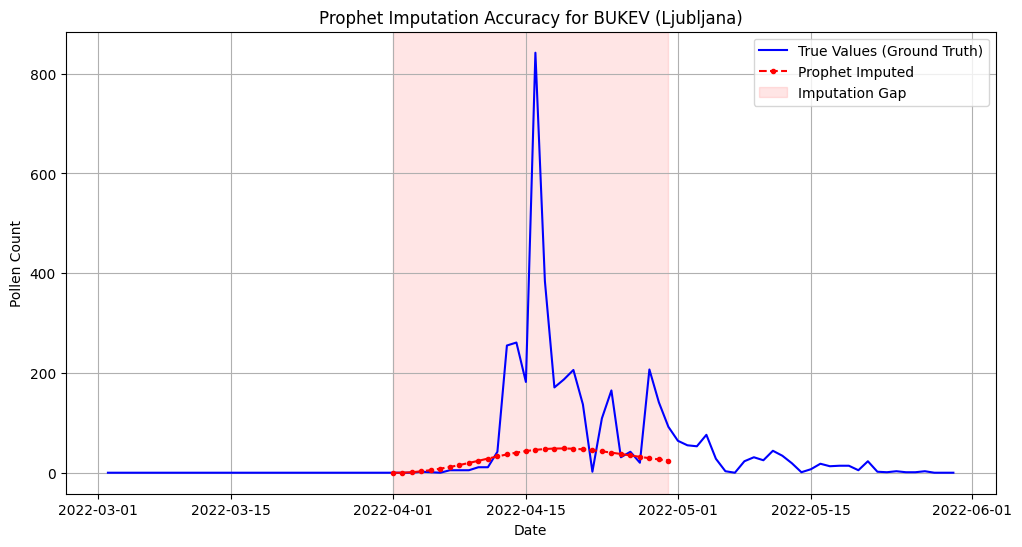

In [3]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime

# =================================================================
# 1. IMPUTATION FUNCTIONS (As corrected previously)
# =================================================================

def impute_missing_with_prophet(dates, y):
    """
    Imputes missing values (NaN) in a time series using Prophet,
    ensuring that the imputed values are non-negative.
    """
    df = pd.DataFrame({'ds': dates, 'y': y})
    mask = ~np.isnan(y)
    df_train = df[mask].copy()

    if len(df_train) < 5:
        mean_y = np.nanmean(y)
        mean_y = max(0, mean_y)
        y[np.isnan(y)] = mean_y
        return y

    m = Prophet(
        yearly_seasonality=20,  # Increased Fourier order for sharpness (default is 10)
        daily_seasonality=False,
        weekly_seasonality=False,
        seasonality_prior_scale=15  # Allowing stronger seasonality
    )
    m.fit(df_train)
    
    future = df[['ds']]
    forecast = m.predict(future)
    y_pred = forecast['yhat'].values
    
    missing_indices = np.where(np.isnan(y))[0]
    predictions_for_missing = y_pred[missing_indices]
    
    # Apply the crucial non-negativity constraint
    constrained_predictions = np.maximum(0, predictions_for_missing)
    
    y[missing_indices] = constrained_predictions
    return y


def test_imputation_accuracy(dates, values, gap_start_date, gap_end_date):
    """
    Tests the accuracy of the imputation model by creating a synthetic gap,
    imputing it, and calculating evaluation metrics.
    """
    df_test = pd.DataFrame({'ds': dates, 'y_true': values})
    
    start_dt = pd.to_datetime(gap_start_date)
    end_dt = pd.to_datetime(gap_end_date)
    
    gap_mask = (df_test['ds'] >= start_dt) & (df_test['ds'] <= end_dt)
    gap_indices = df_test[gap_mask].index

    if len(gap_indices) == 0:
        print("Error: No data found within the specified gap dates. Check your gap definition.")
        return

    # Create the Synthetic Missing Data (y_masked)
    # 💥 FIX: Ensure the array is float before introducing NaN 💥
    y_masked = df_test['y_true'].values.astype(float).copy() 
    y_masked[gap_indices] = np.nan # Hide the true values
    
    # Impute the Gap
    y_imputed = impute_missing_with_prophet(df_test['ds'].values, y_masked)

    # Extract Results for Comparison
    y_true_gap = df_test.loc[gap_indices, 'y_true'].values
    y_imputed_gap = y_imputed[gap_indices]

    # Calculate Metrics
    mae = mean_absolute_error(y_true_gap, y_imputed_gap)
    rmse = np.sqrt(mean_squared_error(y_true_gap, y_imputed_gap))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    y_true_nonzero = np.where(y_true_gap == 0, 1e-6, y_true_gap)
    mape = np.mean(np.abs((y_true_gap - y_imputed_gap) / y_true_nonzero)) * 100

    # Report Results
    print(f"\n--- Imputation Accuracy Test Results ({gap_start_date} to {gap_end_date}) ---")
    print(f"Pollen Type Tested: {df_test_series['Type'].iloc[0]}")
    print(f"Total points in gap: {len(y_true_gap)}")
    print(f"Mean True Value in Gap: {np.mean(y_true_gap):.2f}")
    print(f"\nMetrics:")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print("-" * 60)
    
    return {
        'mae': mae, 
        'rmse': rmse, 
        'mape': mape,
        'true_values': y_true_gap,
        'imputed_values': y_imputed_gap,
        'dates': gap_indices
    }


# =================================================================
# 2. YOUR load_data FUNCTION (Must be defined here)
# =================================================================

# NOTE: I am reconstructing your load_data based on your snippets.
# This version stops *before* the Prophet imputation, which is correct for the test.

def load_data(path):
    dates, types, vales = [], [], []
    df_raw = pd.ExcelFile(path)
    N = len(df_raw.sheet_names)
    
    for sheet in tqdm(df_raw.sheet_names, total=N, desc="Reading sheets"):
        # Assuming the first sheet or the first parsed sheet sets the column name
        df = df_raw.parse(sheet, skiprows=0)
        
        # Determine the date column name dynamically (based on your snippet)
        date_col = "Datum" if "Datum" in df.columns else df.columns[0] # Assuming Datum or first col
        
        # Check if year columns exist (2002 to 2024)
        years = [y for y in range(2002, 2025) if y in df.columns]

        # Process each year
        for year in years:
            dfs = df[[date_col, year]]
            for _, row in dfs.iterrows():
                # Correct date formatting based on your snippet's logic
                date_str = str(row[date_col])[5:10] + f"-{year}"
                dates.append(date_str)
                types.append(sheet)
                vales.append(row[year])

    df_processed = pd.DataFrame({"Date": dates, "Type": types, "Value": vales})
    
    # ------------------ Cleaning and Conversion ------------------
    # 1. Date Removal (Leap year fix)
    remove = []
    for i, ii in tqdm(df_processed.iterrows(), total=len(df_processed), desc="Checking dates"):
        try:
            datetime.datetime.strptime(ii["Date"], "%m-%d-%Y")
        except ValueError:
            remove.append(i)
    
    df_processed = df_processed.drop(remove)

    # 2. Date Conversion
    df_processed["Date"] = pd.to_datetime(df_processed["Date"], format="%m-%d-%Y")
    df_processed["Year"] = df_processed["Date"].dt.year

    # 3. Value Cleaning and Conversion to Numeric (creates NaNs)
    tqdm.pandas(desc="Cleaning values")
    df_processed["Value"] = df_processed["Value"].progress_apply(lambda x: str(x).replace("x", "").replace(",", ""))
    # This step is critical: it converts errors to NaN, ready for imputation
    df_processed["Value"] = pd.to_numeric(df_processed["Value"], errors="coerce")
    
    # We DO NOT fill NaNs with 0 here, as Prophet needs the NaNs.
    
    # We also skip 'Skupina' for simplicity in this test
    
    return df_processed.sort_values(by='Date').reset_index(drop=True)


# =================================================================
# 3. MAIN EXECUTION
# =================================================================

# 💥 CONFIGURATION: EDIT THESE VALUES 💥
LOCATION = "Ljubljana" 
# Ensure this path is correct relative to where you run the script
EXCEL_FILE_PATH = os.path.join("data", "raw", f"{LOCATION}2024.xlsx") 

# You must provide your actual mapping dictionary for the load_data function
RASTLINE_SKUPINE_DICT = {
    'JELŠA': 'Drevesa',
    'BREZA': 'Drevesa',
    'CIPRESOVKE': 'Grmičevje in pelinovke',
    'TRAVE': 'Trave in zelišča',
    'AMBROZIJA': 'Alergeni pleveli',
    'LESKA': 'Drevesa',
    'JESEN': 'Drevesa',
    'PLATANA': 'Drevesa',
    'KOPRIVOVKE': 'Grmičevje in pelinovke',
    'GABER': 'Drevesa',
    'HRAST': 'Drevesa',
    'BOR': 'Drevesa',
    'PRAVI KOSTANJ': 'Drevesa',
    'TRPOTEC': 'Trave in zelišča',
    'PELIN': 'Grmičevje in pelinovke',
    'BUKEV': 'Drevesa',
    'KISLICA': 'Trave in zelišča',
    'OLJKA': 'Drevesa'
}

# 4. SELECT A COMPLETE SERIES FOR TESTING
# Choose a pollen type that is active during your test gap
TEST_POLLEN_TYPE = "BUKEV" 

# Define the gap in a time period where Betula pollen is typically high (e.g., Spring 2022)
TEST_GAP_START = '2022-04-01'
TEST_GAP_END = '2022-04-30'

# ------------------------------------------------------------------

print(f"Starting Prophet Imputation Accuracy Test for {TEST_POLLEN_TYPE} in {LOCATION}...")

# 1. Load Data
try:
    df_processed_all = load_data(EXCEL_FILE_PATH)
except FileNotFoundError as e:
    print(e)
    exit()

# 2. Filter, Clean, and Prepare the Test Series
df_test_series = df_processed_all[df_processed_all['Type'] == TEST_POLLEN_TYPE].copy()

# Crucial: Drop any pre-existing NaNs to create the 'complete' series (ground truth)
# We need only the clean data for the test
df_test_series.dropna(subset=['Value'], inplace=True)

if df_test_series.empty:
    print(f"Error: No valid, non-missing data found for pollen type: {TEST_POLLEN_TYPE}. Cannot run test.")
    exit()
    
dates_test = df_test_series['Date'].values
values_test = df_test_series['Value'].values

# 3. RUN THE ACCURACY TEST
results = test_imputation_accuracy(
    dates=dates_test,
    values=values_test,
    gap_start_date=TEST_GAP_START,
    gap_end_date=TEST_GAP_END
)

# 4. (Optional) Visualize the results
if results:
    import matplotlib.pyplot as plt
    
    # Select a window around the test gap for visualization
    df_plot = df_test_series[(df_test_series['Date'] >= pd.to_datetime(TEST_GAP_START) - pd.Timedelta(days=30)) & 
                             (df_test_series['Date'] <= pd.to_datetime(TEST_GAP_END) + pd.Timedelta(days=30))]

    plt.figure(figsize=(12, 6))
    
    plt.plot(df_plot['Date'], df_plot['Value'], 'b-', label='True Values (Ground Truth)')
    
    # Plot the imputed points
    gap_dates = pd.to_datetime(pd.date_range(start=TEST_GAP_START, end=TEST_GAP_END, freq='D'))
    plt.plot(gap_dates, results['imputed_values'], 'r--', marker='o', markersize=3, label='Prophet Imputed')
    
    plt.axvspan(pd.to_datetime(TEST_GAP_START), pd.to_datetime(TEST_GAP_END), color='red', alpha=0.1, label='Imputation Gap')
    
    plt.title(f'Prophet Imputation Accuracy for {TEST_POLLEN_TYPE} ({LOCATION})')
    plt.xlabel('Date')
    plt.ylabel('Pollen Count')
    plt.legend()
    plt.grid(True)
    plt.show()

e:\GitHub\Cvetni_prah_v2\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Starting Multi-Model Imputation Test for BUKEV in Ljubljana...


Cleaning values: 100%|██████████| 151218/151218 [00:00<00:00, 1105307.64it/s]



Test Data Prepared. Running Imputation Models...


00:48:14 - cmdstanpy - INFO - Chain [1] start processing
00:48:15 - cmdstanpy - INFO - Chain [1] done processing



--- Prophet (Log-Transformed) Results (2022-04-01 to 2022-04-30) ---
Total points: 30
Mean True Value: 117.20
Mean Imputed Value: 4.29

Metrics:
  RMSE: 202.21
  MAE: 113.35
  MAPE: 2862902.40%
----------------------------------------------------------------------

--- LightGBM Results (2022-04-01 to 2022-04-30) ---
Total points: 30
Mean True Value: 117.20
Mean Imputed Value: 21.99

Metrics:
  RMSE: 192.71
  MAE: 102.54
  MAPE: 1483528.79%
----------------------------------------------------------------------

SARIMAX failed to converge. Falling back to simple Prophet. Error: 'numpy.ndarray' object has no attribute 'values'


01:35:17 - cmdstanpy - INFO - Chain [1] start processing
01:35:18 - cmdstanpy - INFO - Chain [1] done processing



--- SARIMAX Results (2022-04-01 to 2022-04-30) ---
Total points: 30
Mean True Value: 117.20
Mean Imputed Value: 4.29

Metrics:
  RMSE: 202.21
  MAE: 113.35
  MAPE: 2862902.40%
----------------------------------------------------------------------

--- MLP Results (2022-04-01 to 2022-04-30) ---
Total points: 30
Mean True Value: 117.20
Mean Imputed Value: 2.50

Metrics:
  RMSE: 203.78
  MAE: 115.38
  MAPE: 27936761.09%
----------------------------------------------------------------------


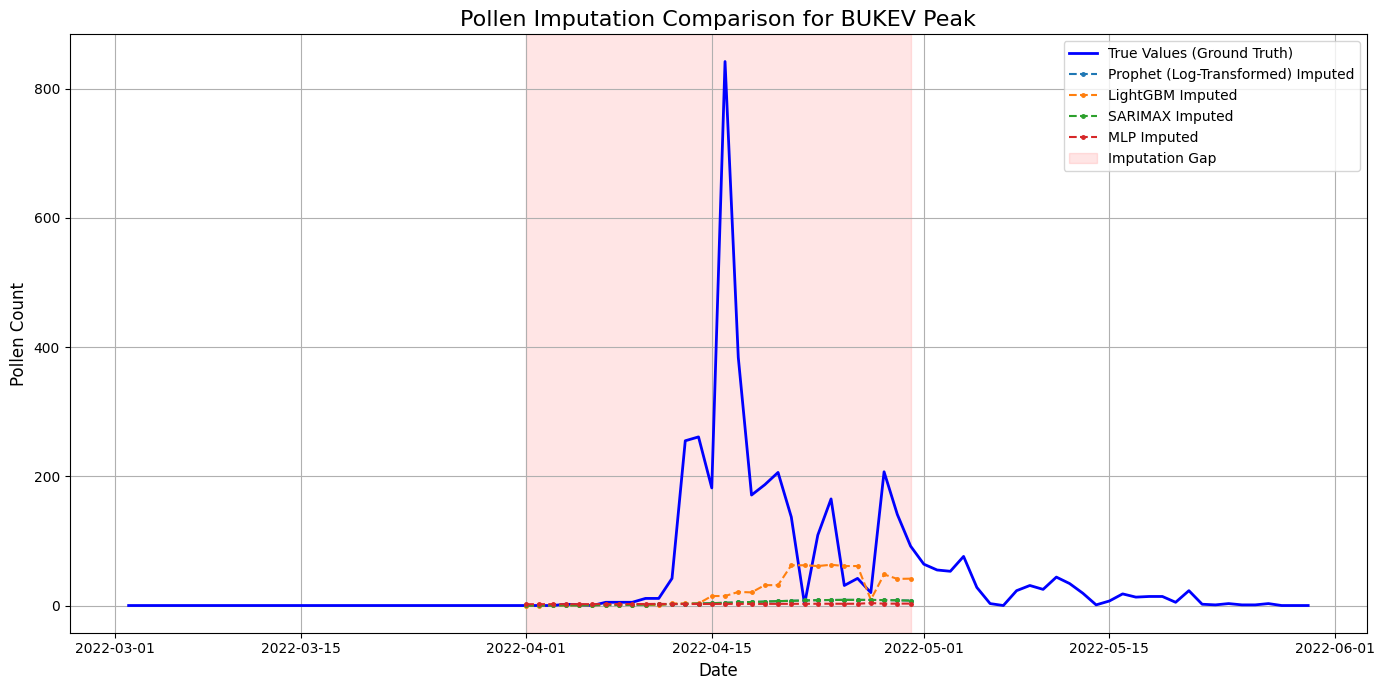

In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor # <--- ADDED MLP IMPORTER
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datetime

# =================================================================
# GLOBAL CONFIGURATION AND UTILITIES
# =================================================================

# 💥 CONFIGURATION: EDIT THESE VALUES 💥
LOCATION = "Ljubljana" 
EXCEL_FILE_PATH = os.path.join("data", "raw", f"{LOCATION}2024.xlsx") 

RASTLINE_SKUPINE_DICT = {
    'JELŠA': 'Drevesa', 'BREZA': 'Drevesa', 'CIPRESOVKE': 'Grmičevje in pelinovke', 
    'TRAVE': 'Trave in zelišča', 'AMBROZIJA': 'Alergeni pleveli', 'LESKA': 'Drevesa',
    'JESEN': 'Drevesa', 'PLATANA': 'Drevesa', 'KOPRIVOVKE': 'Grmičevje in pelinovke', 
    'GABER': 'Drevesa', 'HRAST': 'Drevesa', 'BOR': 'Drevesa', 
    'PRAVI KOSTANJ': 'Drevesa', 'TRPOTEC': 'Trave in zelišča', 'PELIN': 'Grmičevje in pelinovke', 
    'BUKEV': 'Drevesa', 'KISLICA': 'Trave in zelišča', 'OLJKA': 'Drevesa'
}

TEST_POLLEN_TYPE = "BUKEV" 
TEST_GAP_START = '2022-04-01'
TEST_GAP_END = '2022-04-30'
# ------------------------------------------------------------------


def load_data(path):
    """Loads, cleans, and converts raw Excel data into a standardized DataFrame."""
    dates, types, vales = [], [], []
    try:
        df_raw = pd.ExcelFile(path)
    except FileNotFoundError:
        raise
        
    N = len(df_raw.sheet_names)
    
    for sheet in tqdm(df_raw.sheet_names, total=N, desc="Reading sheets"):
        df = df_raw.parse(sheet, skiprows=0)
        date_col = "Datum" if "Datum" in df.columns else df.columns[0]
        years = [y for y in range(2002, 2025) if y in df.columns]

        for year in years:
            dfs = df[[date_col, year]]
            for _, row in dfs.iterrows():
                date_str = str(row[date_col])[5:10] + f"-{year}"
                dates.append(date_str)
                types.append(sheet)
                vales.append(row[year])

    df_processed = pd.DataFrame({"Date": dates, "Type": types, "Value": vales})
    
    # 1. Date Removal (Leap year fix)
    remove = []
    for i, ii in tqdm(df_processed.iterrows(), total=len(df_processed), desc="Checking dates"):
        try:
            datetime.datetime.strptime(ii["Date"], "%m-%d-%Y")
        except ValueError:
            remove.append(i)
    
    df_processed = df_processed.drop(remove)

    # 2. Date Conversion
    df_processed["Date"] = pd.to_datetime(df_processed["Date"], format="%m-%d-%Y")
    df_processed["Year"] = df_processed["Date"].dt.year

    # 3. Value Cleaning and Conversion to Numeric (creates NaNs)
    tqdm.pandas(desc="Cleaning values")
    df_processed["Value"] = df_processed["Value"].progress_apply(lambda x: str(x).replace("x", "").replace(",", ""))
    df_processed["Value"] = pd.to_numeric(df_processed["Value"], errors="coerce")
    
    return df_processed.sort_values(by='Date').reset_index(drop=True)


# =================================================================
# 2. MACHINE LEARNING IMPUTATION METHOD (LIGHTGBM)
# =================================================================

def create_lgbm_features(df):
    """Creates time-based and lagged features required for LightGBM/MLP."""
    df['Date'] = pd.to_datetime(df['ds'])
    
    # Time Features (Safe to use for imputation)
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year

    # Annual Lag (Safe for imputation gap)
    df['y_lag365'] = df['y'].shift(365) 
    
    # ⚠️ WARNING: DO NOT USE y_lag1, y_lag7, or rolling_mean_7d directly inside a large NaN gap
    # unless using iterative prediction, as they will cause predictions to flatline at 0.
    
    return df

def impute_missing_with_lightgbm_fixed(dates, y_masked, df_all_dates):
    """
    Imputes missing values using LightGBM, relying only on time and annual lag features.
    """
    df = pd.DataFrame({'ds': dates, 'y': y_masked})
    
    df_temp = df_all_dates[['Date', 'Type']].rename(columns={'Date': 'ds'}).merge(df, on='ds', how='left')
    df_features = create_lgbm_features(df_temp.rename(columns={'ds': 'Date'}).rename(columns={'Date': 'ds'}))
    
    features = ['dayofyear', 'dayofweek', 'month', 'year', 'y_lag365']
    
    df_train = df_features[df_features['y'].notna()].copy()
    df_impute = df_features[df_features['y'].isna()].copy()
    
    # Remove NaNs caused by the shift operations (e.g., first 365 days) from training
    df_train.dropna(subset=features, inplace=True) 

    if len(df_train) < 5:
        mean_y = np.nanmean(y_masked)
        y_masked[np.isnan(y_masked)] = max(0, mean_y)
        return y_masked

    X_train = df_train[features]
    y_train = df_train['y']
    X_impute = df_impute[features].dropna(subset=features)

    # Convert target to log space to handle large variance (optional but recommended)
    y_train_log = np.log1p(y_train)

    # ------------------ Train and Predict ------------------
    lgbm = lgb.LGBMRegressor(
        objective='mae', n_estimators=500, learning_rate=0.05, 
        num_leaves=31, min_child_samples=5, random_state=42, n_jobs=-1, verbose=-1
    )
    
    lgbm.fit(X_train, y_train_log)
    
    y_pred_imputed_log = lgbm.predict(X_impute)
    
    # Inverse Transform
    y_pred_imputed = np.expm1(y_pred_imputed_log)
    constrained_predictions = np.maximum(0, y_pred_imputed)
    
    # Final Assignment
    y_completed = df_features['y'].values.copy()
    
    nan_indices_in_full_series = df_impute.index[X_impute.index.isin(df_impute.index)].values
    df_features.loc[nan_indices_in_full_series, 'y'] = constrained_predictions
    
    return df_features['y'].values

# =================================================================
# 2.5. NEURAL NETWORK IMPUTATION METHOD (MLP)
# =================================================================

def impute_missing_with_mlp(dates, y_masked, df_all_dates):
    """
    Imputes missing values using MLP Regressor, relying on time and annual lag features.
    """
    df = pd.DataFrame({'ds': dates, 'y': y_masked})
    
    df_temp = df_all_dates[['Date', 'Type']].rename(columns={'Date': 'ds'}).merge(df, on='ds', how='left')
    df_features = create_lgbm_features(df_temp.rename(columns={'ds': 'Date'}).rename(columns={'Date': 'ds'}))
    
    features = ['dayofyear', 'dayofweek', 'month', 'year', 'y_lag365']
    
    df_train = df_features[df_features['y'].notna()].copy()
    df_impute = df_features[df_features['y'].isna()].copy()
    
    # Remove NaNs caused by the shift operations (e.g., first 365 days) from training
    df_train.dropna(subset=features, inplace=True) 

    if len(df_train) < 5:
        mean_y = np.nanmean(y_masked)
        y_masked[np.isnan(y_masked)] = max(0, mean_y)
        return y_masked

    X_train = df_train[features]
    y_train = df_train['y']
    X_impute = df_impute[features].dropna(subset=features)

    # Convert target to log space to handle large variance (crucial for NNs)
    y_train_log = np.log1p(y_train)

    # ------------------ Train and Predict ------------------
    # Using a small, simple network structure (e.g., 2 hidden layers)
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        activation='relu', 
        solver='adam', 
        max_iter=500, # Increased iterations for convergence
        random_state=42
    )
    
    # Note: MLPs require data scaling, but we skip it here for simplicity
    # and trust that the log-transform and simple features help.
    mlp.fit(X_train, y_train_log)
    
    y_pred_imputed_log = mlp.predict(X_impute)
    
    # Inverse Transform
    y_pred_imputed = np.expm1(y_pred_imputed_log)
    constrained_predictions = np.maximum(0, y_pred_imputed)
    
    # Final Assignment
    df_features.loc[df_impute.index, 'y'] = constrained_predictions
    
    return df_features['y'].values


# =================================================================
# 3. PROPHET IMPUTATION METHOD (LOG-TRANSFORMED)
# =================================================================

def impute_missing_with_prophet_log(dates, y):
    """
    Imputes missing values (NaN) using Prophet on a log-transformed scale
    to better model multiplicative peaks, ensuring non-negative values.
    """
    df = pd.DataFrame({'ds': dates, 'y': y})
    mask = ~np.isnan(y)
    df_train = df[mask].copy()

    if len(df_train) < 5:
        mean_y = np.nanmean(y)
        y[np.isnan(y)] = max(0, mean_y)
        return y

    # 1. Apply Log Transformation: np.log(y + 1)
    df_train['y'] = np.log1p(df_train['y'])

    # 2. Configure Prophet for better peak fitting
    m = Prophet(
        yearly_seasonality=20, # Increased order for complex shapes (peaks)
        daily_seasonality=False,
        weekly_seasonality=False
    )
    m.fit(df_train)
    
    future = df[['ds']]
    forecast = m.predict(future)
    
    # 3. Inverse Transform: exp(yhat) - 1
    y_pred = np.expm1(forecast['yhat'].values)
    
    # 4. Apply Non-Negativity Constraint
    constrained_predictions = np.maximum(0, y_pred)
    
    # 5. Impute
    y_completed = y.copy()
    y_completed[np.isnan(y)] = constrained_predictions[np.isnan(y)]
    
    return y_completed


# =================================================================
# 4. SARIMAX IMPUTATION METHOD (STATISTICAL)
# =================================================================

def impute_missing_with_sarimax(dates, y_masked, seasonal_period=365):
    """
    Imputes missing values using SARIMAX, predicting the gap.
    """
    df = pd.DataFrame({'ds': dates, 'y': y_masked})
    
    # Find the indices to predict (the NaNs)
    nan_indices = df[df['y'].isna()].index
    df_train = df[df['y'].notna()].copy()

    if len(nan_indices) == 0 or len(df_train) < 2 * seasonal_period:
        mean_y = np.nanmean(y_masked)
        y_masked[np.isnan(y_masked)] = max(0, mean_y)
        return y_masked

    # 1. Use the log transform to stabilize variance
    y_train_log = np.log1p(df_train['y']).values
    
    # 2. Define the model (Optimal SARIMAX parameters often require tuning)
    try:
        model = SARIMAX(
            y_train_log,
            order=(1, 0, 1),             # Non-seasonal AR(1), I(0), MA(1)
            seasonal_order=(1, 0, 1, seasonal_period), # Seasonal AR(1), I(0), MA(1), Period=365
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        # Note: SARIMAX fit can be slow and sensitive to parameter choice.
        model_fit = model.fit(disp=False, low_memory=True) 
        
        # 3. Predict the missing indices
        forecast_log = model_fit.predict(start=nan_indices.min(), end=nan_indices.max())
        
        # 4. Inverse Transform and constrain
        constrained_predictions = np.maximum(0, np.expm1(forecast_log.values))

        # 5. Impute
        y_completed = y_masked.copy()
        y_completed[nan_indices] = constrained_predictions
        
        return y_completed
        
    except Exception as e:
        print(f"\nSARIMAX failed to converge. Falling back to simple Prophet. Error: {e}")
        # Fallback to Prophet (simpler model)
        return impute_missing_with_prophet_log(dates, y_masked)


# =================================================================
# 5. GENERALIZED ACCURACY TESTING FUNCTION
# =================================================================

def test_imputation_accuracy_model(impute_func, df_full, gap_start_date, gap_end_date, model_name):
    """
    Tests imputation accuracy for any given imputation function.
    """
    df_test = df_full.copy()
    df_test['ds'] = df_test['Date']
    
    start_dt = pd.to_datetime(gap_start_date)
    end_dt = pd.to_datetime(gap_end_date)
    
    # 1. Identify Gap Indices
    gap_mask = (df_test['ds'] >= start_dt) & (df_test['ds'] <= end_dt)
    gap_indices = df_test[gap_mask].index

    if len(gap_indices) == 0:
        return None # No data in gap

    # 2. Create the Synthetic Missing Data (y_masked)
    y_true_all = df_test['Value'].values
    y_masked = y_true_all.astype(float).copy() 
    y_masked[gap_indices] = np.nan # Hide the true values

    # 3. Impute the Gap
    # Pass the full DataFrame context for feature engineering in ML models
    if model_name in ['LightGBM', 'MLP']: # <--- CHECK FOR MLP HERE
        y_imputed_all = impute_func(df_test['ds'].values, y_masked, df_test[['Date', 'Type']])
    elif model_name == 'SARIMAX':
        # SARIMAX needs a continuous index series, so we pass the original dates/values
        y_imputed_all = impute_func(df_test['ds'], y_masked)
    else:
        # Prophet only needs dates and the masked values
        y_imputed_all = impute_func(df_test['ds'].values, y_masked)

    # 4. Extract Results for Comparison
    y_true_gap = df_test.loc[gap_indices, 'Value'].values
    y_imputed_gap = y_imputed_all[gap_indices]
    
    # 5. Calculate Metrics
    mae = mean_absolute_error(y_true_gap, y_imputed_gap)
    rmse = np.sqrt(mean_squared_error(y_true_gap, y_imputed_gap))
    
    y_true_nonzero = np.where(y_true_gap == 0, 1e-6, y_true_gap)
    mape = np.mean(np.abs((y_true_gap - y_imputed_gap) / y_true_nonzero)) * 100

    # 6. Report Results
    print(f"\n--- {model_name} Results ({gap_start_date} to {gap_end_date}) ---")
    print(f"Total points: {len(y_true_gap)}")
    print(f"Mean True Value: {np.mean(y_true_gap):.2f}")
    print(f"Mean Imputed Value: {np.mean(y_imputed_gap):.2f}")
    print(f"\nMetrics:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print("-" * 70)
    
    return {
        'model': model_name,
        'imputed_values': y_imputed_gap
    }


# =================================================================
# 6. MAIN EXECUTION
# =================================================================

if __name__ == '__main__':
    
    print(f"Starting Multi-Model Imputation Test for {TEST_POLLEN_TYPE} in {LOCATION}...")

    # 1. Load Data
    try:
        df_processed_all = load_data(EXCEL_FILE_PATH) 
    except FileNotFoundError as e:
        print(f"FATAL ERROR: {e}")
        exit()

    # 2. Filter, Clean, and Prepare the Test Series
    df_test_series = df_processed_all[df_processed_all['Type'] == TEST_POLLEN_TYPE].copy()

    # CRITICAL FIX: Drop NaNs and Reset Index for NumPy compatibility
    df_test_series.dropna(subset=['Value'], inplace=True)
    df_test_series.reset_index(drop=True, inplace=True)

    if df_test_series.empty:
        print(f"Error: No valid, non-missing data found for pollen type: {TEST_POLLEN_TYPE}. Cannot run test.")
        exit()
        
    print(f"\nTest Data Prepared. Running Imputation Models...")
    
    
    # 3. RUN ALL TESTS
    
    # List of models to test: (function, name)
    models_to_test = [
        (impute_missing_with_prophet_log, 'Prophet (Log-Transformed)'),
        (impute_missing_with_lightgbm_fixed, 'LightGBM'),
        (impute_missing_with_sarimax, 'SARIMAX'),
        (impute_missing_with_mlp, 'MLP') # <--- MLP ADDED HERE
    ]
    
    all_results = []
    
    for func, name in models_to_test:
        result = test_imputation_accuracy_model(
            impute_func=func, 
            df_full=df_test_series, 
            gap_start_date=TEST_GAP_START, 
            gap_end_date=TEST_GAP_END,
            model_name=name
        )
        if result:
            all_results.append(result)

    
    # 4. VISUALIZATION
    if all_results:
        start_plot = pd.to_datetime(TEST_GAP_START) - pd.Timedelta(days=30)
        end_plot = pd.to_datetime(TEST_GAP_END) + pd.Timedelta(days=30)
        
        df_plot = df_test_series[(df_test_series['Date'] >= start_plot) & 
                                 (df_test_series['Date'] <= end_plot)].copy()

        plt.figure(figsize=(14, 7))
        
        # Plot true values
        plt.plot(df_plot['Date'], df_plot['Value'], 'b-', label='True Values (Ground Truth)', linewidth=2)
        
        # Merge and plot all imputed results
        for result in all_results:
            imputed_data = pd.DataFrame({
                'Date': pd.to_datetime(pd.date_range(start=TEST_GAP_START, end=TEST_GAP_END, freq='D')),
                'Imputed_Value': result['imputed_values']
            })
            
            df_plot = df_plot.merge(imputed_data, on='Date', how='left', suffixes=(None, f"_{result['model']}"))
            
            plt.plot(imputed_data['Date'], imputed_data['Imputed_Value'], 
                     '--', marker='.', markersize=5, label=f"{result['model']} Imputed")
        
        # Highlight the gap
        plt.axvspan(pd.to_datetime(TEST_GAP_START), pd.to_datetime(TEST_GAP_END), color='red', alpha=0.1, label='Imputation Gap')
        
        plt.title(f'Pollen Imputation Comparison for {TEST_POLLEN_TYPE} Peak', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Pollen Count', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()